# Классификация текстов в Keras

---

**ФИО:** Волгин Алексей Дмитриевич

---


Задание: создать модель для решения задачи классификации текста - определение тональности отзывов с использованием фреймворка Keras.

В этой работе булем решать задачу определение тональности отзывов с использованием фреймворка Keras. В ноутбуке ниже приведен пример создания нейронной сети для классификаци
и текстов на датасете, состоящим из отзывов на Tesla, бинарная лкассификация - 2 класса - позитивный отзыв и негативный отзыв. (Ссылка на датасет в примере https://drive.google.com/file/d/1PKL86ByMBl0M_rWjcjgoO29ojh9QmTU8/view?usp=sharing )

В задании для самостоятельной разработки необходимо загрузить датасет и построить 2 архитектуры сети (с использованием слоев Conv1D и SimpleRNN), вывести результаты обучения.

In [25]:
import numpy as np
import pandas as pd
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gdown
import os
import re

import pickle
import matplotlib.pyplot as plt
%matplotlib inline

####
Создать нейронную сеть по распознаванию позитивных и негативных отзывы
людей по автомобилю Tesla. (tesla.zip).

In [2]:
gdown.download('https://drive.google.com/uc?id=1PKL86ByMBl0M_rWjcjgoO29ojh9QmTU8', None, quiet=True)

'tesla.zip'

In [4]:
import os

In [15]:
zip_path = '/content/tesla.zip'

In [16]:
!unzip -qo -O UTF-8 tesla.zip -d tesla/

UnZip 6.00 of 20 April 2009, by Info-ZIP.  Maintained by C. Spieler.  Send
bug reports using http://www.info-zip.org/zip-bug.html; see README for details.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test compressed archive data
  -u  update files, create if necessary      -z  display archive comment only
  -v  list verbosely/show version info       -T  timestamp archive to latest
  -x  exclude files that follow (in xlist)   -d  extract files into exdir
modifiers:
  -n  never overwrite existing files         -q  quiet mode (-qq => quieter)
  -o  overwrite files WITHOUT prompting      -a  auto-convert any text files
  -j  junk paths (do not make directories)   -aa treat ALL files

In [28]:
# функции для чтения файла
def read_text(file_name):
  read_file = open(file_name, 'r', encoding='utf-8')
  text = read_file.read()
  return text.replace("\n", " ")


class_names = ["positive", "negative"] # создаем 2 класса позитивных и негативных отзывов
num_classes = len(class_names)

texts_list = []

for i in os.listdir('./content/tesla/'):
    print(path)
    texts_list.append(read_text('./content/tesla/'+i))
    print(i, 'добавлен в обучающую выборку')


texts_len = [len(text) for text in texts_list]

/content/tesla/Негативный отзыв.txt
Негативный отзыв.txt добавлен в обучающую выборку
/content/tesla/Негативный отзыв.txt
Позитивный отзыв.txt добавлен в обучающую выборку


**Форимирование обучающего и тестового набора**

In [29]:
# раздедение на тестовую и обучающую выборки
train_len_shares = [(i - round(i/5)) for i in texts_len]
t_num = 0
for train_len_share in train_len_shares:
    t_num += 1
    print(f'Доля 80% от текста №{t_num}: {train_len_share} токенов')

Доля 80% от текста №1: 107628 токенов
Доля 80% от текста №2: 170705 токенов


In [30]:
from itertools import chain # импортируем функцию для добавления текстов в ыборки

train_data = []
test_data = []

for i in range(len(texts_list)):
    train_len = int(len(texts_list[i]) * 0.8)

    # Добавим тексты в выборки функцией chain()
    train_data = list(chain(train_data, ([texts_list[i][:train_len]])))
    test_data = list(chain(test_data, ([texts_list[i][train_len:]])))

In [31]:
# Задание параметров преобразования
VOCAB_SIZE = 5000                        # Объем словаря для токенизатора
WIN_SIZE = 500                         # Длина отрезка текста (окна) в словах
WIN_HOP = 100                          # Шаг окна разбиения текста на векторы

** Создание токенайзера**

In [32]:
# Создание токенайзера
tokenizer = Tokenizer(
    num_words=VOCAB_SIZE,
    filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
    lower=True,
    split=' ',
    oov_token='неизвестное_слово',
    char_level=False
)
# Обучение токенайзера

tokenizer.fit_on_texts(train_data)
items = list(tokenizer.word_index.items())

In [33]:
# Вывод нескольких наиболее часто встречающихся слов
print(items[:10])
print("Размер словаря", len(items))

[('неизвестное_слово', 1), ('и', 2), ('в', 3), ('не', 4), ('на', 5), ('это', 6), ('что', 7), ('с', 8), ('тесла', 9), ('за', 10)]
Размер словаря 10336


In [34]:
# Преобразование  в последовательность
seq_train = tokenizer.texts_to_sequences(train_data)
seq_test = tokenizer.texts_to_sequences(test_data)

In [35]:
# Функция разбиения последовательности на отрезки скользящим окном
def split_sequence(sequence, win_size, hop):
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, hop)]

# Функция формирования выборок из последовательностей индексов
def vectorize_sequence(seq_list, win_size, hop):
    class_count = len(seq_list)
    x, y = [], []
    for cls in range(class_count):
        vectors = split_sequence(seq_list[cls], win_size, hop)
        x += vectors
        y += [utils.to_categorical(cls, class_count)] * len(vectors)
    return np.array(x), np.array(y)

In [36]:
#  формирования обучающуся  и тесстовой выборок
x_train, y_train = vectorize_sequence(seq_train, WIN_SIZE, WIN_HOP)
x_test, y_test = vectorize_sequence(seq_test, WIN_SIZE, WIN_HOP)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(418, 500) (418, 2)
(100, 500) (100, 2)


**Векторизация текста**

Преобразование в Bag of Words

In [37]:
# Формирование выборок текстов в виде разреженных матриц (bag of words
# На входе .sequences_to_matrix() подается список, метод .tolist() выполняет преобразование типа

x_train_01 = tokenizer.sequences_to_matrix(x_train.tolist())
x_test_01 = tokenizer.sequences_to_matrix(x_test.tolist())

In [38]:
# вывод размерности преобразованной в  bag of words обучающей выборки и 1 примера (первые 100 элементов)
print(x_train_01.shape)
print(x_train_01[0][0:100])

(418, 5000)
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1.
 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 1. 1.]


In [39]:
# вывод размерности преобразованной в  bag of words тестовой выборки
x_test_01.shape

(100, 5000)

**Создание и обучение модели**

In [40]:
# создание и обучение модели
model = Sequential([
    Dense(128, input_shape=x_test_01.shape[1:], activation='relu'),
    Dense(64, activation='relu'),
    Dense(y_test.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_history = model.fit(x_train_01, y_train, epochs=10, validation_split=0.1)

C:\Users\aleks\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7415 - loss: 0.4812 - val_accuracy: 0.8571 - val_loss: 0.3013
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 0.0574
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.0662e-05 - val_accuracy: 1.0000 - val_loss: 0.0251
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4988e-05 - val_accuracy: 1.0000 - val_loss: 0.0193
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3566e-05 - val_accuracy: 1.0000 - val_loss: 0.0180
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2430e-05 - val_accuracy: 1.0000 - val_loss: 0.0181
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2529e-05 - val_accuracy: 1.0000 - val_loss: 0.0185
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1505e-05 - val_acc

**Оценка модели на тестовой выборке**

In [41]:
y_pred = model.predict(x_test_01)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


**Вывод матрицы ошибок**

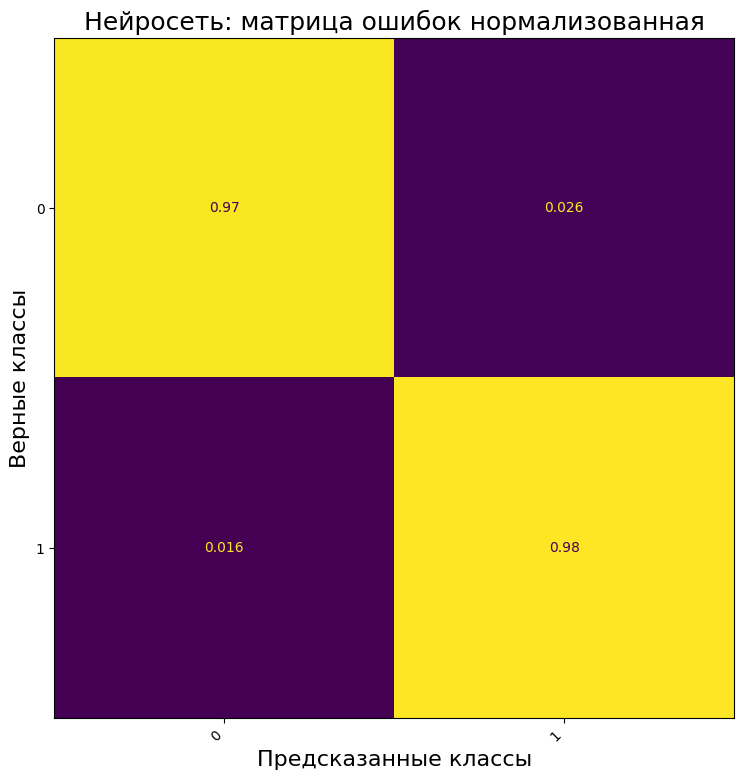

In [42]:
cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
# Округление значений матрицы ошибок
cm = np.around(cm, 3)

# Отрисовка матрицы ошибок
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f'Нейросеть: матрица ошибок нормализованная', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=ax)
plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
plt.xlabel('Предсказанные классы', fontsize=16)
plt.ylabel('Верные классы', fontsize=16)
fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
plt.show()

####
**Создаybt архитектуры сети с исользование слоя Embedding**

In [43]:
model_2 = Sequential([
    Embedding(VOCAB_SIZE, 200, input_length=500),
    Conv1D(200, 5, padding='valid', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(200, activation='relu'),
    Dropout(0.2),
    Dense(len(class_names), activation='sigmoid')
])
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_2_history = model_2.fit(x_train, y_train, epochs=5, validation_split=0.1)

Epoch 1/5


C:\Users\aleks\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.5820 - loss: 0.6706 - val_accuracy: 1.0000 - val_loss: 0.5457
Epoch 2/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9653 - loss: 0.4861 - val_accuracy: 1.0000 - val_loss: 0.5104
Epoch 3/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.1895 - val_accuracy: 1.0000 - val_loss: 0.3996
Epoch 4/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0320 - val_accuracy: 1.0000 - val_loss: 0.2203
Epoch 5/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 1.0000 - val_loss: 0.1372


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


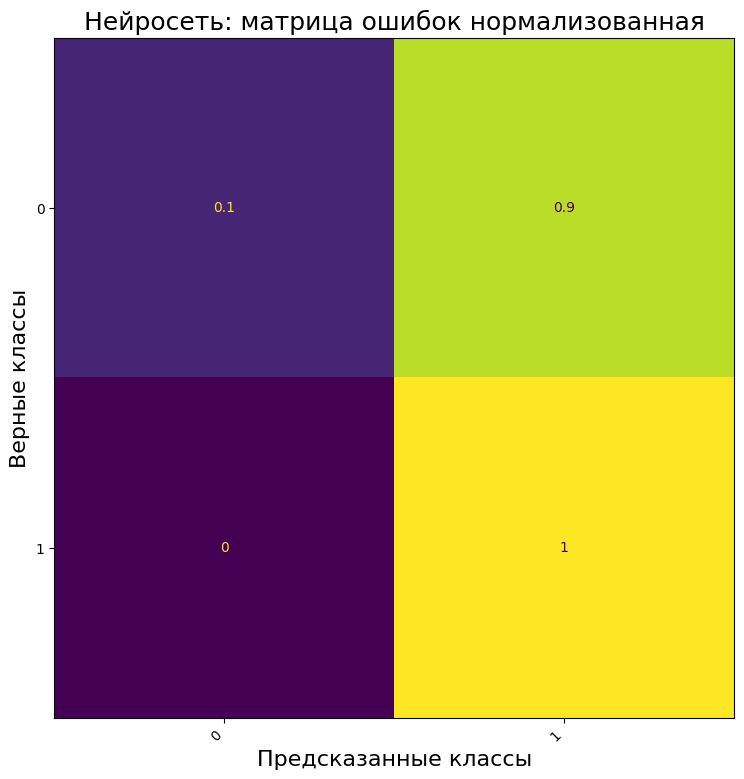

0.5515

In [44]:
y_pred = model_2.predict(x_test)

cm = confusion_matrix(np.argmax(y_test, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
# Округление значений матрицы ошибок
cm = np.around(cm, 3)

# Отрисовка матрицы ошибок
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title(f'Нейросеть: матрица ошибок нормализованная', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=ax)
plt.gca().images[-1].colorbar.remove()  # Стирание ненужной цветовой шкалы
plt.xlabel('Предсказанные классы', fontsize=16)
plt.ylabel('Верные классы', fontsize=16)
fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси при необходимости
plt.show()

cm.diagonal().mean()

#### Задание
1. Для загруженного датачета отзывов создайте 2 архитектуры сети с использованием слоев Conv1D и SimpleRNN с использованием векторизации Bag of Words и Embedding.
2. Обучите сеть, добейтесь результата точности сети не менее 90% на проверочной выборке модели с использованием векторизации Bag of Words и 80% - для модели Embedding.
3. Выведите архитектуры сетей.

4. Выведите результаты и постройте матрицу ошибок.

## Контрольные вопросы

**Опишите для чего нужен и как работает tokenizer**

Ваш ответ: Tokenizer - это важный компонент в задачах обработки естественного языка (NLP), его основная функция заключается в преобразовании текста в числовую форму, понятную для нейронных сетей.

Tokenizer работает следующим образом:

1. Разбиение текста на токены: Tokenizer разбивает входной текст на отдельные "токены" - единицы текста, такие как слова, символы пунктуации, числа и т.д. Это можно сделать, используя различные методы разделения, например, по пробелам, знакам препинания и т.д.

2. Создание словаря: Tokenizer создает словарь, в котором каждому уникальному токену присваивается уникальный числовой индекс (ID). Этот словарь используется для преобразования текста в последовательность числовых индексов.

3. Преобразование текста в последовательность индексов: После создания словаря, tokenizer преобразует входной текст в последовательность числовых индексов, соответствующих токенам в тексте.

4. Pad and truncate: Tokenizer может также выполнять pad and truncate - это процесс выравнивания последовательностей до фиксированной длины, необходимой для работы нейронной сети.

**Опишите параметры tokenizer**

Ваш ответ:
1. Vocabulary Size (Размер словаря): Определяет, сколько уникальных токенов будет включено в словарь. Это важный параметр, так как он влияет на размер входных данных для нейронной сети.

2. Padding/Truncation Strategy (Стратегия заполнения/усечения): Определяет, как tokenizer будет обрабатывать последовательности разной длины. Это может быть "pre" (добавление/удаление токенов в начало) или "post" (добавление/удаление токенов в конец) последовательности.

3. Padding Value (Значение заполнения): Определяет, каким значением будут заполняться последовательности до фиксированной длины. Обычно это 0.

4. OOV Token (Токен для слов вне словаря): Определяет, какой токен будет использоваться для слов, которых нет в словаре. Это позволяет обрабатывать ранее незнакомые слова.

5. Lowercase (Приведение к нижнему регистру): Определяет, следует ли приводить все слова к нижнему регистру перед tokenизацией.

6. Maximal Length (Максимальная длина): Определяет максимальную длину последовательности, которую tokenizer будет обрабатывать. Более длинные последовательности будут усечены.

**Объясните концепцию векторизации Bag of Words.**

Ваш ответ: Концепция Bag of Words (BoW) - это один из способов векторизации текстовых данных, который преобразует текст в числовой вектор, понятный для алгоритмов машинного обучения.

Идея Bag of Words заключается в следующем:

1. Создание словаря: Из всего корпуса текстов собирается словарь, содержащий все уникальные слова (токены).

2. Создание векторов: Для каждого текстового документа создается вектор, длина которого равна размеру словаря. Каждый элемент вектора соответствует одному слову из словаря и содержит количество (частоту) появления этого слова в данном документе.

**Опишите слой Embedding и его параметры**

Ваш ответ: Слой Embedding:
- Преобразует каждое слово (представленное как индекс в словаре) в плотное числовое представление (вектор).
- Это одна из ключевых операций в обработке естественного языка с использованием нейронных сетей.

Параметры слоя Embedding:
1. VOCAB_SIZE - размер словаря, то есть количество уникальных слов в наборе данных. Это определяет размерность входного слоя.
2. 200 - размерность вектора эмбеддинга, то есть количество признаков, которые будут использоваться для представления каждого слова. Это гиперпараметр, который нужно подбирать в зависимости от задачи.
3. input_length=500 - максимальная длина входной последовательности слов. Это необходимо для правильного формирования входных данных.

